# Final Project
# Shourav Makkapati

In [1]:
import geopandas as gpd
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask

In [2]:
#Data Collection
counties = gpd.read_file('counties.geojson')
conn = sqlite3.connect("counties_tracts.db")

In [3]:
counties.head()

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


In [4]:
pd.read_sql("""SELECT * FROM sqlite_master""", conn)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [5]:
pd.read_sql("""SELECT * FROM counties""", conn)

,index,NAME,COUNTY,AREALAND,AREAWATER
0,0,Racine County,101,861533739,1190103013
1,1,Clark County,019,3133378070,23239614
2,2,Wood County,141,2054044751,41994799
3,3,Rusk County,107,2366092584,44813690
4,4,Ozaukee County,089,603514413,2287415379
...,...,...,...,...,...
67,67,Washburn County,129,2064515991,145563849
68,68,Monroe County,081,2333270295,18986835
69,69,Richland County,103,1518120276,8153423
70,70,Price County,099,3248866440,62102368


In [6]:
area = pd.read_sql("""SELECT * FROM counties""", conn)
counties = counties.merge(area, left_on='NAME', right_on='NAME')
counties

,NAME,POP100,geometry,index,COUNTY,AREALAND,AREAWATER
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",0,101,861533739,1190103013
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",1,019,3133378070,23239614
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2,141,2054044751,41994799
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",3,107,2366092584,44813690
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",4,089,603514413,2287415379
...,...,...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",67,129,2064515991,145563849
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",68,081,2333270295,18986835
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",69,103,1518120276,8153423
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830...",70,099,3248866440,62102368


In [7]:
area

,index,NAME,COUNTY,AREALAND,AREAWATER
0,0,Racine County,101,861533739,1190103013
1,1,Clark County,019,3133378070,23239614
2,2,Wood County,141,2054044751,41994799
3,3,Rusk County,107,2366092584,44813690
4,4,Ozaukee County,089,603514413,2287415379
...,...,...,...,...,...
67,67,Washburn County,129,2064515991,145563849
68,68,Monroe County,081,2333270295,18986835
69,69,Richland County,103,1518120276,8153423
70,70,Price County,099,3248866440,62102368


In [8]:
HU100 = pd.read_sql("""SELECT * FROM tracts""", conn)
HU100 = HU100[['COUNTY', 'HU100']]
HU100 = HU100.groupby('COUNTY').sum()
counties = counties.merge(HU100, left_on='COUNTY', right_on='COUNTY')
counties

,NAME,POP100,geometry,index,COUNTY,AREALAND,AREAWATER,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",0,101,861533739,1190103013,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",1,019,3133378070,23239614,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2,141,2054044751,41994799,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",3,107,2366092584,44813690,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",4,089,603514413,2287415379,36267
...,...,...,...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",67,129,2064515991,145563849,12979
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",68,081,2333270295,18986835,19204
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",69,103,1518120276,8153423,8868
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830...",70,099,3248866440,62102368,11120


This table above has all 72 counties of wisconsin and shows various statistics such as population, county number, arealand, areawater and HU100. 

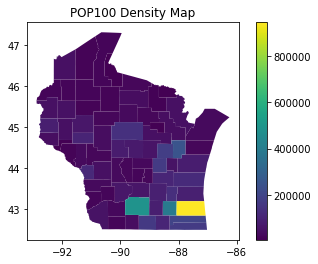

In [9]:
ax = counties.plot(column='POP100', legend=True);
plt.title("POP100 Density Map");

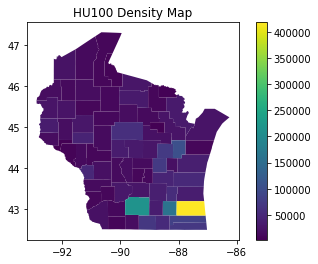

In [10]:
counties.plot(column='HU100', legend=True);
plt.title("HU100 Density Map");

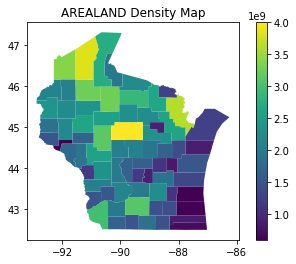

In [11]:
counties.plot(column='AREALAND', legend=True);
plt.title("AREALAND Density Map");

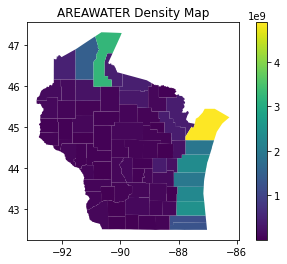

In [12]:
counties.plot(column='AREAWATER', legend=True);
plt.title("AREAWATER Density Map");

In [13]:
#Comparing the Relationship between Population and Housing Units(each dot will represent a county)\
model = LinearRegression()
model.fit(counties[["HU100"]], counties["POP100"])
model.score(counties[["HU100"]], counties["POP100"])
scores = cross_val_score(model, counties[["HU100"]], counties["POP100"])
mean = round(scores.mean(),2)
std = round(scores.std(),2)
print(f"{mean} is the average of how much variance in POP100 can a linear regression model explain based only on HU100")
print(f"{std} is the standard deviation of the cross validation scores")




0.97 is the average of how much variance in POP100 can a linear regression model explain based only on HU100
0.04 is the standard deviation of the cross validation scores


<AxesSubplot:xlabel='HU100', ylabel='POP100'>

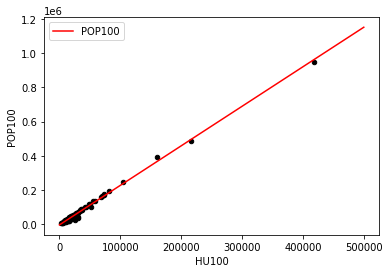

In [14]:
prediction_df = pd.DataFrame({"HU100": range(1, 500000)})
prediction_df["POP100"] = model.predict(prediction_df)

ax = prediction_df.plot.line(x="HU100", y="POP100", color="red")
counties.plot.scatter(x="HU100", y="POP100", ax=ax, color="black")

This graph above shows a very clear relationship between Population of a county and its housing units, it is also seen in the density maps further above how clear the relationship is and only in high population areas are there also high housing units. It makes sense that counties with high populations have higher housing units. However it is interesting seeing that county with the highest population and housing units has the lowest arealands. It is on Lake Michigan which may cause an increase in people wanting to live in that county. 

In [15]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
land = rasterio.open("wi.tif")

#land_use.values()

In [16]:
def glt(county):
    mke = counties.loc[counties['NAME']==county]
    matrix, _ = mask(land, mke.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    matrixB = matrix.reshape(-1,1)
    matrixB = np.delete(matrixB, np.where(matrixB == 0))
    land_types={}
    for i in matrixB:
        if i in land_types:
            land_types[i]+=1
        else:
            land_types[i]=1
    for key in land_use:
        if land_use[key] not in land_types:
            land_types[land_use[key]]=0
    tester={}
    for key in land_use:
        tester[key] = land_types[land_use[key]]
    return tester

In [17]:
mke_lt = glt('Milwaukee County')
lands = list(mke_lt.keys())
nums = list(mke_lt.values())

mke_lt

{'open_water': 2725860,
 'ice_snow': 0,
 'developed_open': 79436,
 'developed_low': 177920,
 'developed_med': 203357,
 'developed_high': 93041,
 'barren': 2848,
 'deciduous': 35635,
 'evergreen': 85,
 'mixed_forest': 3396,
 'dwarf_scrub': 0,
 'shrub_scrub': 2296,
 'grassland': 14858,
 'sedge': 0,
 'lichens': 0,
 'moss': 0,
 'pasture': 12267,
 'crops': 32624,
 'woody_wetlands': 33085,
 'herbacious_wetlands': 6433}

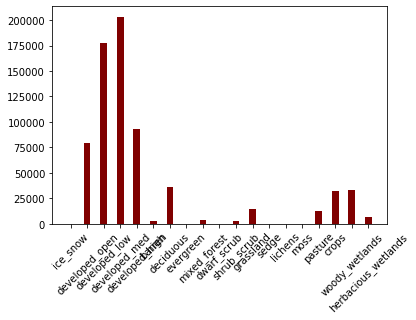

In [18]:
plt.bar(lands[1:], nums[1:], color ='maroon',
        width = 0.4)
plt.xticks(rotation = 45);


This graph above shows a barplot of the different type of land plots within the Milwaukee County. I left open water out of this graph as it was far and above the highest amount and was so far above it caused the graph to be distorted making it extremely difficult to view the other land types. However it makes sense for Milwaukee county to have a majority of open water as it sits on Lake Michigan. Also interesting with this being Milwaukee County and MKE being the biggest City in Wisconsin the devoleped high section is very low compared to low, medium or open. This shows that even in the county with the biggest city Wisconsin has a more open land plot form and low development even in the most populated areas.

In [19]:
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

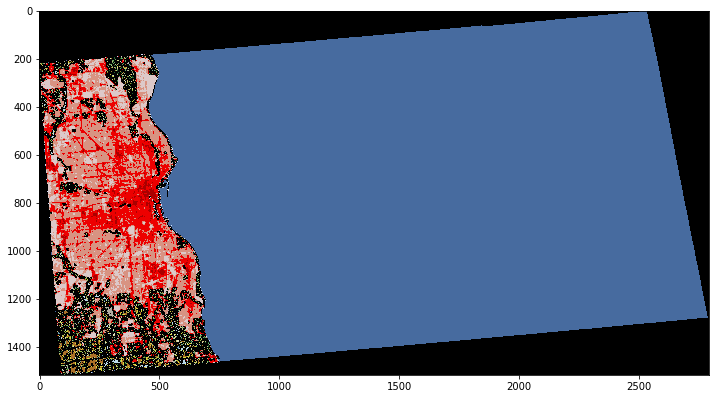

In [20]:
mke = counties.loc[counties['NAME']=="Milwaukee County"]
matrix, _ = mask(land, mke.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
#plt.imshow(matrix)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, custom_cmap, vmin=0, vmax=255)

The above map shows Milwaukee County and the various land types located within it. This link https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description has the different land types of the world and this map shows the different types for milwaukee county and I will be looking more in depth for it. 

In [21]:
matrixB = matrix.reshape(-1,1)
matrixB = np.delete(matrixB, np.where(matrixB == 0))
land_types={}
for i in matrixB:
    if i in land_types:
        land_types[i]+=1
    else:
        land_types[i]=1
#land_types

In [22]:
for key in land_use:
    if land_use[key] not in land_types:
        land_types[land_use[key]]=0
#land_types

In [23]:
tester={}
for key in land_use:
    tester[key] = land_types[land_use[key]]
tester

{'open_water': 2725860,
 'ice_snow': 0,
 'developed_open': 79436,
 'developed_low': 177920,
 'developed_med': 203357,
 'developed_high': 93041,
 'barren': 2848,
 'deciduous': 35635,
 'evergreen': 85,
 'mixed_forest': 3396,
 'dwarf_scrub': 0,
 'shrub_scrub': 2296,
 'grassland': 14858,
 'sedge': 0,
 'lichens': 0,
 'moss': 0,
 'pasture': 12267,
 'crops': 32624,
 'woody_wetlands': 33085,
 'herbacious_wetlands': 6433}

In [24]:
clt={}
for i in counties['NAME']:
    clt[i] = glt(i)
#clt

In [25]:
lt = pd.DataFrame.from_dict(clt, orient='index')
lt.reset_index(inplace=True)
lt.rename(columns = {'index':'NAME'}, inplace = True)
lt = lt[['NAME', 'open_water', 'developed_open', 'developed_low', 'developed_med', 'developed_high', 'barren', 'deciduous','evergreen','mixed_forest', 'shrub_scrub', 'grassland','pasture', 'crops', 'woody_wetlands', 'herbacious_wetlands']]
lt



,NAME,open_water,developed_open,developed_low,developed_med,developed_high,barren,deciduous,evergreen,mixed_forest,shrub_scrub,grassland,pasture,crops,woody_wetlands,herbacious_wetlands
0,Racine County,1320092,54221,83597,59855,23884,4461,86254,1590,8267,1699,18677,69649,462605,61449,23302
1,Clark County,14573,120056,30699,9656,1919,599,902921,49457,188675,19640,10634,80259,1553026,445911,79307
2,Wood County,47659,91622,61463,21553,8515,533,350840,68729,96558,15899,56804,53408,732268,532283,190807
3,Rusk County,52947,63109,24302,4638,1344,391,1146894,8038,89546,29640,17979,130167,363303,632029,114452
4,Ozaukee County,2540180,51067,63252,28051,7237,3043,49483,2044,8015,1541,10725,85922,261467,86753,13363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Washburn County,130214,72527,28146,8638,1753,2623,1103187,66542,247093,28091,31248,176703,116871,390789,51205
68,Monroe County,20409,96714,53564,19121,4214,2159,863147,67649,161365,34125,94574,384552,559076,180770,72235
69,Richland County,9211,54895,30584,4521,1091,444,755779,7398,61480,2816,16411,422021,278112,33324,17788
70,Price County,74559,93689,20960,4144,1095,247,1088098,34306,431353,46571,64495,142956,58131,1436607,181610


In [26]:
counties = counties.merge(lt, left_on='NAME', right_on='NAME')


In [27]:
house_prices = pd.read_csv('Houseprices.csv')
# Found at this link https://cdn.nar.realtor/sites/default/files/documents/2021-q4-county-median-home-prices-and-local-affordability-by-state-03-08-2022.pdf
house_prices

,County Name,Median Home Price Q4,Monthly Payment 2021 Q4,Monthly Payment 2020 Q4
0,Adams County,160903.0,617.0,511.0
1,Ashland County,138811.0,532.0,441.0
2,Barron County,215947.0,721.0,597.0
3,Bayfield County,208892.0,801.0,664.0
4,Brown County,237345.0,910.0,764.0
...,...,...,...,...
67,Waukesha County,360031.0,1380.0,1179.0
68,Waupaca County,183977.0,705.0,584.0
69,Waushara County,179313.0,687.0,570.0
70,Winnebago County,200366.0,768.0,644.0


In [28]:
plt2 = house_prices.merge(lt, left_on = 'County Name', right_on = 'NAME')
plt2  = plt2.drop(['NAME'], axis=1)
plt2

,County Name,Median Home Price Q4,Monthly Payment 2021 Q4,Monthly Payment 2020 Q4,open_water,developed_open,developed_low,developed_med,developed_high,barren,deciduous,evergreen,mixed_forest,shrub_scrub,grassland,pasture,crops,woody_wetlands,herbacious_wetlands
0,Adams County,160903.0,617.0,511.0,127124,74929,42875,6636,1195,924,404791,156174,211831,51165,122082,49111,448178,216844,67521
1,Ashland County,138811.0,532.0,441.0,3599902,62961,22177,7977,2124,7581,905891,115332,698618,48055,29726,125287,22751,875051,73441
2,Barron County,215947.0,721.0,597.0,77714,100191,55247,17776,5741,1090,693592,22513,118332,3487,8795,410252,834049,157050,54726
3,Bayfield County,208892.0,801.0,664.0,1623389,128326,36700,9319,1907,5308,1426662,358609,1271854,202524,68959,247882,34805,430474,28807
4,Brown County,237345.0,910.0,764.0,244485,96467,142693,78815,32366,5222,90226,2184,4950,2020,4471,98067,787576,157444,24962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Waukesha County,360031.0,1380.0,1179.0,71261,213709,236835,103037,35482,12292,187516,13904,19461,1294,4136,199564,291008,172866,108290
68,Waupaca County,183977.0,705.0,584.0,43752,93845,42934,14371,4570,1790,296595,41816,138659,2304,4129,112474,825614,493926,85210
69,Waushara County,179313.0,687.0,570.0,37132,68399,33641,6664,1294,907,252386,98645,131655,6941,13850,55010,740106,262281,125348
70,Winnebago County,200366.0,768.0,644.0,407817,61974,96985,59047,21016,3806,31101,1128,6869,320,1359,90377,651366,62449,169365


In [29]:
X = plt2.iloc[:,-15:]
y = plt2.iloc[:,1]
regr = LinearRegression()
regr.fit(X, y)

LinearRegression()

In [30]:
scores = cross_val_score(regr, X, y)
mean = round(scores.mean(),2)
std = round(scores.std(),2)
print(f"{mean} is the average of how much variance in Home Price can a linear regression model explain based only on amount of land types in a county")
print(f"{std} is the standard deviation of the cross validation scores")


0.22 is the average of how much variance in Home Price can a linear regression model explain based only on amount of land types in a county
0.15 is the standard deviation of the cross validation scores


The above score shows that there is no real relationship between the land types and the prices of houses in individual counties. 

In [31]:
print(regr.coef_)

[ 9.73642414e-03  1.01151322e+00  8.00400914e-02  3.43453538e+00
 -8.44851811e+00 -2.45076488e+00 -4.86547632e-02 -4.38518390e-02
 -1.02449608e-02  1.15180877e-01 -3.46783352e-01 -4.43935454e-03
 -4.61217621e-02 -4.92770608e-02 -2.35779583e-02]


In [32]:
counties = counties.merge(house_prices, left_on = 'NAME', right_on = 'County Name')
counties

,NAME,POP100,geometry,index,COUNTY,AREALAND,AREAWATER,HU100,open_water,developed_open,...,shrub_scrub,grassland,pasture,crops,woody_wetlands,herbacious_wetlands,County Name,Median Home Price Q4,Monthly Payment 2021 Q4,Monthly Payment 2020 Q4
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",0,101,861533739,1190103013,82164,1320092,54221,...,1699,18677,69649,462605,61449,23302,Racine County,244990.0,939.0,792.0
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",1,019,3133378070,23239614,15076,14573,120056,...,19640,10634,80259,1553026,445911,79307,Clark County,156117.0,598.0,496.0
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2,141,2054044751,41994799,34088,47659,91622,...,15899,56804,53408,732268,532283,190807,Wood County,160780.0,616.0,511.0
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",3,107,2366092584,44813690,8883,52947,63109,...,29640,17979,130167,363303,632029,114452,Rusk County,139179.0,534.0,442.0
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",4,089,603514413,2287415379,36267,2540180,51067,...,1541,10725,85922,261467,86753,13363,Ozaukee County,360626.0,1382.0,1181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",67,129,2064515991,145563849,12979,130214,72527,...,28091,31248,176703,116871,390789,51205,Washburn County,193182.0,741.0,614.0
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",68,081,2333270295,18986835,19204,20409,96714,...,34125,94574,384552,559076,180770,72235,Monroe County,190236.0,729.0,604.0
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",69,103,1518120276,8153423,8868,9211,54895,...,2816,16411,422021,278112,33324,17788,Richland County,171704.0,658.0,545.0
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830...",70,099,3248866440,62102368,11120,74559,93689,...,46571,64495,142956,58131,1436607,181610,Price County,150348.0,576.0,478.0


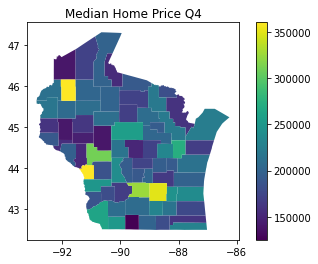

In [33]:
ax = counties.plot(column=plt2.iloc[:,1], legend=True);
plt.title("Median Home Price Q4");

In [34]:
counties.loc[counties['NAME']=="Dane County"]

,NAME,POP100,geometry,index,COUNTY,AREALAND,AREAWATER,HU100,open_water,developed_open,...,shrub_scrub,grassland,pasture,crops,woody_wetlands,herbacious_wetlands,County Name,Median Home Price Q4,Monthly Payment 2021 Q4,Monthly Payment 2020 Q4
59,Dane County,488073,"POLYGON ((-89.01202 43.11090, -89.01200 43.111...",59,025,3100993706,106127786,216022,118197,168511,...,7005,3726,473639,1664346,71543,162125,Dane County,349685.0,1340.0,1142.0


In [35]:
df2 = counties.merge(house_prices, left_on = 'NAME', right_on = 'County Name')
df2

,NAME,POP100,geometry,index,COUNTY,AREALAND,AREAWATER,HU100,open_water,developed_open,...,woody_wetlands,herbacious_wetlands,County Name_x,Median Home Price Q4_x,Monthly Payment 2021 Q4_x,Monthly Payment 2020 Q4_x,County Name_y,Median Home Price Q4_y,Monthly Payment 2021 Q4_y,Monthly Payment 2020 Q4_y
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",0,101,861533739,1190103013,82164,1320092,54221,...,61449,23302,Racine County,244990.0,939.0,792.0,Racine County,244990.0,939.0,792.0
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",1,019,3133378070,23239614,15076,14573,120056,...,445911,79307,Clark County,156117.0,598.0,496.0,Clark County,156117.0,598.0,496.0
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2,141,2054044751,41994799,34088,47659,91622,...,532283,190807,Wood County,160780.0,616.0,511.0,Wood County,160780.0,616.0,511.0
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",3,107,2366092584,44813690,8883,52947,63109,...,632029,114452,Rusk County,139179.0,534.0,442.0,Rusk County,139179.0,534.0,442.0
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",4,089,603514413,2287415379,36267,2540180,51067,...,86753,13363,Ozaukee County,360626.0,1382.0,1181.0,Ozaukee County,360626.0,1382.0,1181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",67,129,2064515991,145563849,12979,130214,72527,...,390789,51205,Washburn County,193182.0,741.0,614.0,Washburn County,193182.0,741.0,614.0
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",68,081,2333270295,18986835,19204,20409,96714,...,180770,72235,Monroe County,190236.0,729.0,604.0,Monroe County,190236.0,729.0,604.0
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",69,103,1518120276,8153423,8868,9211,54895,...,33324,17788,Richland County,171704.0,658.0,545.0,Richland County,171704.0,658.0,545.0
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830...",70,099,3248866440,62102368,11120,74559,93689,...,1436607,181610,Price County,150348.0,576.0,478.0,Price County,150348.0,576.0,478.0


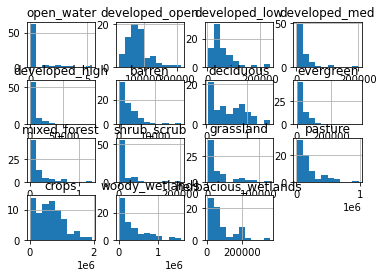

In [36]:
df3 = lt.iloc[:, 1:]
df3.hist(); 

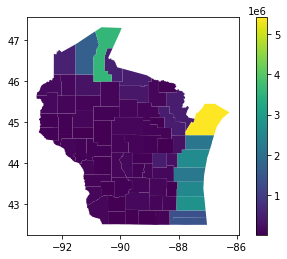

In [37]:
counties.plot(column=counties['open_water'], legend=True);